#### Breast Cancer Prediction Modelling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            balanced_accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay)
import joblib

In [3]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # Load preprocessed datasets
    X_train = pd.read_csv('X_train_scaled.csv')
    X_test = pd.read_csv('X_test_scaled.csv')

    y_train = pd.read_csv('y_train.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()

    # The .squueze() method removes dimensions of size 1 , converting a DataFrame to a Series
    # The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects,
    # preventing potential errors during model training and evaluation.

    # Load preprecessing objects
    scaler = joblib.load('scaler.pkl')

    print("...Preprocessed data loaded successfully!!!...")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # Display class distribution
    print("\nClass Distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\n Test set:")
    print(y_test.value_counts().sort_index())

        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: X_train_scaled.csv.csv, X_test_scaled.csv")
    print("                y_train.csv, y_test.csv")
    print("                scaler.pkl")

LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!!...
Training set: (455, 20)
Test set: (114, 20)

Class Distribution:
Training set:
diagnosis
Benign       285
Malignant    170
Name: count, dtype: int64

 Test set:
diagnosis
Benign       72
Malignant    42
Name: count, dtype: int64


In [4]:
# Let's create a dictionary that stores model
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier()
}

Training LogisticRegression
LogisticRegression Accuracy - 0.9912280701754386


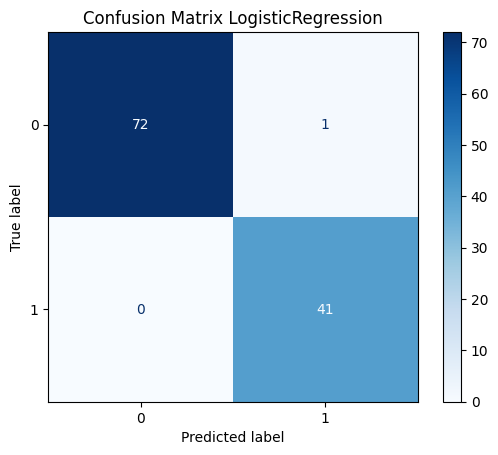

Training RandomForestClassifier
RandomForestClassifier Accuracy - 0.9736842105263158


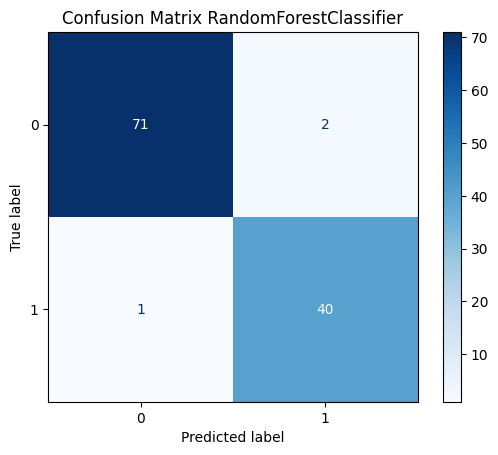

In [5]:
# Initiate the model
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    results[model] = accuracy
    print(f"{model_name} Accuracy - {accuracy}")

    # Let's include a confusion matrix
    cm = confusion_matrix(y_pred, y_test)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Let's plot with the model name as title
    display.plot(cmap="Blues")
    plt.title(f"Confusion Matrix {model_name}")
    plt.show()


In [6]:
# Pipeline
ml_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('lr', LogisticRegression(max_iter=5000))
    ])

In [7]:

# Let's tune the LogisticRegression - set Hyperparameter tune
param_grid = {
    "lr__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "lr__penalty": ['l2', 'none'],
    "lr__solver": ['lbfgs', 'liblinear', 'saga'],
    "lr__class_weight": [None, 'balanced']
}

In [8]:
# Cross validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:

# Let's define the RandomSearchCV
random_search = RandomizedSearchCV(ml_pipe, param_distributions=param_grid,n_iter=30, cv=cv,verbose=2, n_jobs=-1,scoring='f1_macro', random_state=42)
random_search.fit(X_train, y_train)
print(f"Best Parameter for LogisticRegression: {random_search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameter for LogisticRegression: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__class_weight': 'balanced', 'lr__C': 0.1}


In [10]:
# Check the best model/cross validation
best_model = random_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross Validation score: {cv_scores}")
print(f"Mean cross validation score: {cv_scores.mean()}")

Cross Validation score: [0.94505495 1.         0.96703297 0.98901099 0.96703297]
Mean cross validation score: 0.9736263736263735


In [11]:
# Use the best model to predict
y_pred_rf = best_model.predict(X_test)
print("\n Classification report")
print(classification_report(y_pred_rf, y_test, zero_division=1))


 Classification report
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97        70
   Malignant       0.98      0.93      0.95        44

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [12]:
# Let's save our best model as a pickle
joblib.dump(best_model, 'best_model.pkl')

# Let's save the scaler as a pickle
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']